# 第四章　暖冷房設備 / Chapter 4 Heating and cooling equipment

## 第二節　ダクト式セントラル空調機 / Section 2 Duct type central air conditioner

In [1]:
import numpy as np

## 試算例

### 初期条件

In [2]:
def get_default_central_heating():
    
    house_base = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34}
    house_ENV = {"A_env": 307.51, "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.8, 'method': '当該住宅の外皮面積の合計を用いて評価する', 'tatekata': '戸建住宅'}

    H_A = {'type': 'ダクト式セントラル空調機', 'duct_insulation': '全てもしくは一部が断熱区画外である',
           'VAV': False, 'general_ventilation': True, 'EquipmentSpec': '入力しない'}
    C_A = {'type': 'ダクト式セントラル空調機', 'duct_insulation': '全てもしくは一部が断熱区画外である',
           'VAV': False, 'general_ventilation': True, 'EquipmentSpec': '入力しない'}
    
    return house_base, house_ENV, H_A, C_A

### 計算

In [3]:
def calc_results(house_base, house_ENV, H_A, C_A):

    from pyhees.section4_1 import get_virtual_heating_devices, get_alpha_UT_H_A, calc_E_G_C_d_t, calc_E_K_C_d_t, calc_E_M_C_d_t
    from pyhees.section4_1_a import calc_heating_mode
    from pyhees.section2_1_b import get_f_prim
    from pyhees.section2_2 import calc_heating_load, calc_cooling_load
    from pyhees.section3_1 import get_Q
    from pyhees.section3_2 import calc_insulation_performance

    import pyhees.section4_2 as dc
    import pyhees.section4_2_a as dc_a
    import pyhees.section4_2_b as dc_spec


    sol_region = None
    NV_MR = 0
    NV_OR = 0
    r_A_ufvnt = None
    underfloor_insulation = False
    TS = None
    HEX = None
    SHC = None

    mode_H = '住戸全体を連続的に暖房する方式'
    mode_C = '住戸全体を連続的に冷房する方式'
    H_MR = None
    H_OR = None

    house_ENV['A_A'] = house_base['A_A']


    # ---- 外皮の計算 ----
    r_env, Q_dash, mu_H, mu_C = calc_insulation_performance(**house_ENV)
    # 外皮の断熱性能の計算
    if house_ENV is not None:
        # 熱損失係数
        Q = get_Q(Q_dash)
    else:
        Q = None
        mu_H, mu_C = None, None

    
    # 実質的な暖房機器の仕様を取得
    spec_MR, spec_OR = get_virtual_heating_devices(house_base['region'], H_MR, H_OR)

    # 暖房方式及び運転方法の区分
    mode_MR, mode_OR = calc_heating_mode(region=house_base['region'], H_MR=spec_MR, H_OR=spec_OR)

    # 暖房負荷の取得
    L_T_H_d_t_i, _ = calc_heating_load(house_base['region'], sol_region, house_base['A_A'], house_base['A_MR'], house_base['A_OR'],
                        Q, mu_H, mu_C, NV_MR, NV_OR, TS, r_A_ufvnt, HEX, underfloor_insulation, mode_H, mode_C, spec_MR, spec_OR, mode_MR, mode_OR, SHC)

    # 冷房負荷の取得
    L_CS_d_t, L_CL_d_t = calc_cooling_load(house_base['region'], house_base['A_A'], house_base['A_MR'], house_base['A_OR'], Q, mu_H, mu_C, NV_MR, NV_OR, 
                          r_A_ufvnt, underfloor_insulation, mode_C, mode_H, mode_MR, mode_OR, TS, HEX)

    # 暖房仕様の取得
    # 定格暖房能力
    if 'q_hs_rtd_H' in H_A:
        q_hs_rtd_H = H_A['q_hs_rtd_H']
    else:
        q_hs_rtd_H = dc_spec.get_q_hs_rtd_H(house_base['region'], house_base['A_A'])

    # 定格風量(暖房)
    if 'V_fan_rtd_H' in H_A:
        V_fan_rtd_H = H_A['V_fan_rtd_H']
    else:
        V_fan_rtd_H = dc_spec.get_V_fan_rtd_H(q_hs_rtd_H)

    # 設計風量(暖房)
    if 'V_hs_dsgn_H' in H_A:
        V_hs_dsgn_H = H_A['V_hs_dsgn_H']
    else:
        V_hs_dsgn_H = dc_spec.get_V_fan_dsgn_H(V_fan_rtd_H)

    # 定格冷房能力
    q_hs_rtd_C = None

    # 設計風量(冷房)
    V_hs_dsgn_C = None

    # VAV方式の採用
    if 'VAV' in H_A:
        VAV = H_A['VAV']

    # 全般換気機能の有無
    if 'general_ventilation' in H_A:
        general_ventilation = H_A['general_ventilation']

    # ダクトが通過する空間
    if 'duct_insulation' in H_A:
        duct_insulation = H_A['duct_insulation']

    # 暖房仕様の取得
    if H_A['EquipmentSpec'] == '入力しない':
        # 付録B
        EquipmentSpec = '入力しない'
        q_hs_rtd_H = dc_spec.get_q_hs_rtd_H(house_base['region'], house_base['A_A'])
        q_hs_mid_H = dc_spec.get_q_hs_mid_H(q_hs_rtd_H)
        q_hs_min_H = dc_spec.get_q_hs_min_H(q_hs_rtd_H)
        P_hs_rtd_H = dc_spec.get_P_hs_rtd_H(q_hs_rtd_H)
        V_fan_rtd_H = dc_spec.get_V_fan_rtd_H(q_hs_rtd_H)
        V_fan_mid_H = dc_spec. get_V_fan_mid_H(q_hs_mid_H)
        P_fan_rtd_H = dc_spec.get_P_fan_rtd_H(V_fan_rtd_H)
        P_fan_mid_H = dc_spec.get_P_fan_mid_H(V_fan_mid_H)
        P_hs_mid_H = np.nan
    elif H_A['EquipmentSpec'] == '定格能力試験の値を入力する':
        EquipmentSpec = '定格能力試験の値を入力する'
        q_hs_rtd_H = H_A['q_hs_rtd_H']
        P_hs_rtd_H = H_A['P_hs_rtd_H']
        V_fan_rtd_H =H_A['V_fan_rtd_H']
        P_fan_rtd_H = H_A['P_fan_rtd_H']
        q_hs_mid_H = dc_spec.get_q_hs_mid_H(q_hs_rtd_H)
        q_hs_min_H = dc_spec.get_q_hs_min_H(q_hs_rtd_H)
        V_fan_mid_H = dc_spec. get_V_fan_mid_H(q_hs_mid_H)
        P_fan_mid_H = dc_spec.get_P_fan_mid_H(V_fan_mid_H)
        P_hs_mid_H = np.nan
    elif H_A['EquipmentSpec'] == '定格能力試験と中間能力試験の値を入力する':
        EquipmentSpec = '定格能力試験と中間能力試験の値を入力する'
        q_hs_rtd_H = H_A['q_hs_rtd_H']
        P_hs_rtd_H = H_A['P_hs_rtd_H']
        V_fan_rtd_H = H_A['V_fan_rtd_H']
        P_fan_rtd_H = H_A['P_fan_rtd_H']
        q_hs_mid_H = H_A['q_hs_mid_H']
        P_hs_mid_H = H_A['P_hs_mid_H']
        V_fan_mid_H = H_A['V_fan_mid_H']
        P_fan_mid_H = H_A['P_fan_mid_H']
        q_hs_min_H = dc_spec.get_q_hs_min_H(q_hs_rtd_H)
    else:
        raise ValueError(H_A['EquipmentSpec'])

     # 設計風量(暖房)
    if 'V_hs_dsgn_H' in H_A:
        V_hs_dsgn_H = H_A['V_hs_dsgn_H']
    else:
        V_hs_dsgn_H = dc_spec.get_V_fan_dsgn_H(V_fan_rtd_H)


    # 未処理暖房負荷と機器の計算に必要な変数を取得
    _, Q_UT_H_d_t_i, _, _, Theta_hs_out_d_t, Theta_hs_in_d_t, \
    _, _, V_hs_supply_d_t, V_hs_vent_d_t, C_df_H_d_t = dc.calc_Q_UT_A(house_base['A_A'], house_base['A_MR'], house_base['A_OR'], r_env, mu_H, mu_C,
                                                                    q_hs_rtd_H, q_hs_rtd_C, V_hs_dsgn_H,
                                                                    V_hs_dsgn_C, Q, VAV, general_ventilation,
                                                                    duct_insulation, house_base['region'], L_T_H_d_t_i, L_CS_d_t, L_CL_d_t)
    Q_UT_H_A_d_t = np.sum(Q_UT_H_d_t_i, axis=0)

    alpha_UT_H_A = get_alpha_UT_H_A(house_base['region'])
    E_UT_H_d_t = Q_UT_H_A_d_t * alpha_UT_H_A


    # 暖房用の電気消費量
    E_E_H_d_t = dc_a.calc_E_E_H_d_t(Theta_hs_out_d_t=Theta_hs_out_d_t, Theta_hs_in_d_t=Theta_hs_in_d_t, V_hs_supply_d_t=V_hs_supply_d_t, 
                                    V_hs_vent_d_t=V_hs_vent_d_t, C_df_H_d_t=C_df_H_d_t, q_hs_rtd_H=q_hs_rtd_H, V_hs_dsgn_H=V_hs_dsgn_H,
                                    P_hs_mid_H=P_hs_mid_H, P_hs_rtd_H=P_hs_rtd_H, P_fan_rtd_H=P_fan_rtd_H, P_fan_mid_H=P_fan_mid_H,
                                    q_hs_min_H=q_hs_min_H, q_hs_mid_H=q_hs_mid_H, V_fan_rtd_H=V_fan_rtd_H, V_fan_mid_H=V_fan_mid_H,
                                    EquipmentSpec=EquipmentSpec, region=house_base['region'])

    # 暖房用のガス消費量
    E_G_H_d_t = dc.get_E_G_H_d_t()

    # 暖房用の灯油
    E_K_H_d_t = dc.get_E_K_H_d_t()

    # 暖房用のその他の燃料
    E_M_H_d_t = dc.get_E_M_H_d_t()
    


    # 冷房仕様の取得
    if C_A['EquipmentSpec'] == '入力しない':
        # 付録B
        EquipmentSpec = '入力しない'
        q_hs_rtd_C = dc_spec.get_q_hs_rtd_C(house_base['region'], house_base['A_A'])
        q_hs_mid_C = dc_spec.get_q_hs_mid_C(q_hs_rtd_C)
        q_hs_min_C = dc_spec.get_q_hs_min_C(q_hs_rtd_C)
        P_hs_rtd_C = dc_spec.get_P_hs_rtd_C(q_hs_rtd_C)
        V_fan_rtd_C = dc_spec.get_V_fan_rtd_C(q_hs_rtd_C)
        V_fan_mid_C = dc_spec.get_V_fan_mid_C(q_hs_mid_C)
        P_fan_rtd_C = dc_spec.get_P_fan_rtd_C(V_fan_rtd_C)
        P_fan_mid_C = dc_spec.get_P_fan_mid_C(V_fan_mid_C)
        P_hs_mid_C = np.nan
    elif C_A['EquipmentSpec'] == '定格能力試験の値を入力する':
        EquipmentSpec = '定格能力試験の値を入力する'
        q_hs_rtd_C = C_A['q_hs_rtd_C']
        P_hs_rtd_C = C_A['P_hs_rtd_C']
        V_fan_rtd_C = C_A['V_fan_rtd_C']
        P_fan_rtd_C = C_A['P_fan_rtd_C']
        q_hs_mid_C = dc_spec.get_q_hs_mid_C(q_hs_rtd_C)
        q_hs_min_C = dc_spec.get_q_hs_min_C(q_hs_rtd_C)
        V_fan_mid_C = dc_spec.get_V_fan_mid_C(q_hs_mid_C)
        P_fan_mid_C = dc_spec.get_P_fan_mid_C(V_fan_mid_C)
        P_hs_mid_C = np.nan
    elif C_A['EquipmentSpec'] == '定格能力試験と中間能力試験の値を入力する':
        EquipmentSpec = '定格能力試験と中間能力試験の値を入力する'
        q_hs_rtd_C = C_A['q_hs_rtd_C']
        P_hs_rtd_C = C_A['P_hs_rtd_C']
        V_fan_rtd_C = C_A['V_fan_rtd_C']
        P_fan_rtd_C = C_A['P_fan_rtd_C']
        q_hs_mid_C = C_A['q_hs_mid_C']
        P_hs_mid_C = C_A['P_hs_mid_C']
        V_fan_mid_C = C_A['V_fan_mid_C']
        P_fan_mid_C = C_A['P_fan_mid_C']
        q_hs_min_C = dc_spec.get_q_hs_min_C(q_hs_rtd_C)
    else:
        raise ValueError(C_A['EquipmentSpec'])
    
    # 設計風量(冷房)
    if 'V_hs_dsgn_C' in C_A:
        V_hs_dsgn_C = C_A['V_hs_dsgn_C']
    else:
        V_hs_dsgn_C = dc_spec.get_V_fan_dsgn_C(V_fan_rtd_C)

    # 定格暖房能力
    q_hs_rtd_H = None

    # 設計風量(暖房)
    V_hs_dsgn_H = None

    # 未処理冷房負荷の設計一次エネルギー消費量相当値と機器の計算に必要な変数を取得
    E_UT_C_d_t, _, _, _, Theta_hs_out_d_t, Theta_hs_in_d_t, X_hs_out_d_t, \
    X_hs_in_d_t, V_hs_supply_d_t, V_hs_vent_d_t, _ = dc.calc_Q_UT_A(house_base['A_A'], house_base['A_MR'], house_base['A_OR'], r_env, mu_H, mu_C, q_hs_rtd_H,
                                                                    q_hs_rtd_C, V_hs_dsgn_H, V_hs_dsgn_C, Q, C_A['VAV'], C_A['general_ventilation'], 
                                                                    C_A['duct_insulation'], house_base['region'], L_T_H_d_t_i, L_CS_d_t, L_CL_d_t)

    # 冷房用の電気消費量
    E_E_C_d_t = dc_a.get_E_E_C_d_t(Theta_hs_out_d_t=Theta_hs_out_d_t, Theta_hs_in_d_t=Theta_hs_in_d_t, X_hs_out_d_t=X_hs_out_d_t,
                              X_hs_in_d_t=X_hs_in_d_t, V_hs_supply_d_t=V_hs_supply_d_t, V_hs_vent_d_t=V_hs_vent_d_t,
                              q_hs_rtd_C=q_hs_rtd_C, V_hs_dsgn_C=V_hs_dsgn_C, q_hs_mid_C=q_hs_mid_C, q_hs_min_C=q_hs_min_C,
                              P_fan_rtd_C=P_fan_rtd_C, P_fan_mid_C=P_fan_mid_C, P_hs_rtd_C=P_hs_rtd_C, P_hs_mid_C=P_hs_mid_C,
                              V_fan_rtd_C=V_fan_rtd_C, V_fan_mid_C=V_fan_mid_C, EquipmentSpec=EquipmentSpec, region=house_base['region'])

    # 冷房用のガス消費量
    E_G_C_d_t = calc_E_G_C_d_t()

    # 冷房用の灯油消費量
    E_K_C_d_t = calc_E_K_C_d_t()

    # 冷房用のその他の燃料
    E_M_C_d_t = calc_E_M_C_d_t()



    # 電気の一次エネルギー換算係数
    f_prim = get_f_prim()

    E_H_d_t = E_E_H_d_t * f_prim / 1000 + E_G_H_d_t + E_K_H_d_t + E_M_H_d_t + E_UT_H_d_t
    E_C_d_t = E_E_C_d_t * f_prim / 1000 + E_G_C_d_t + E_K_C_d_t + E_M_C_d_t + E_UT_C_d_t
    print(f'E_H_d_t={np.sum(E_H_d_t)}MJ/a')
    print(f'E_C_d_t={np.sum(E_C_d_t)}MJ/a')
    
    return E_H_d_t, E_C_d_t


In [4]:
def get_each_graph(_E_H_d_t, _E_C_d_t):

    import matplotlib.pyplot as plt

    _E_H_d = np.sum(_E_H_d_t.reshape(365,24), axis = 1)
    _E_C_d = np.sum(_E_C_d_t.reshape(365,24), axis = 1)

    fig = plt.figure(figsize = (20,7))

    grh_day = fig.add_subplot(211)
    grh_day.set_ylabel('MJ/d')
    grh_day.set_xlabel('day')
    grh_day.plot(_E_C_d, label = "E_C")    
    grh_day.plot(_E_H_d, label = "E_H")
    grh_day.legend()

    grh_date = fig.add_subplot(212)
    grh_date.set_ylabel('MJ/h')
    grh_date.set_xlabel('hour')

    grh_date.plot(_E_C_d_t.reshape(365,24)[151], label = "E_C:6/1")
    grh_date.plot(_E_C_d_t.reshape(365,24)[212], label = "E_C:8/1")
    grh_date.plot(_E_H_d_t.reshape(365,24)[334], label = "E_H:12/1")
    grh_date.plot(_E_H_d_t.reshape(365,24)[59], label = "E_H:3/1")
    grh_date.legend()

    plt.show()


### 計算条件1

- 初期条件での計算

In [5]:
house_base, house_ENV, H_A, C_A = get_default_central_heating()

_E_H_d_t_010, _E_C_d_t_010 = calc_results(house_base, house_ENV, H_A, C_A)

E_H_d_t=36558.649546681496MJ/a
E_C_d_t=14773.136498249625MJ/a


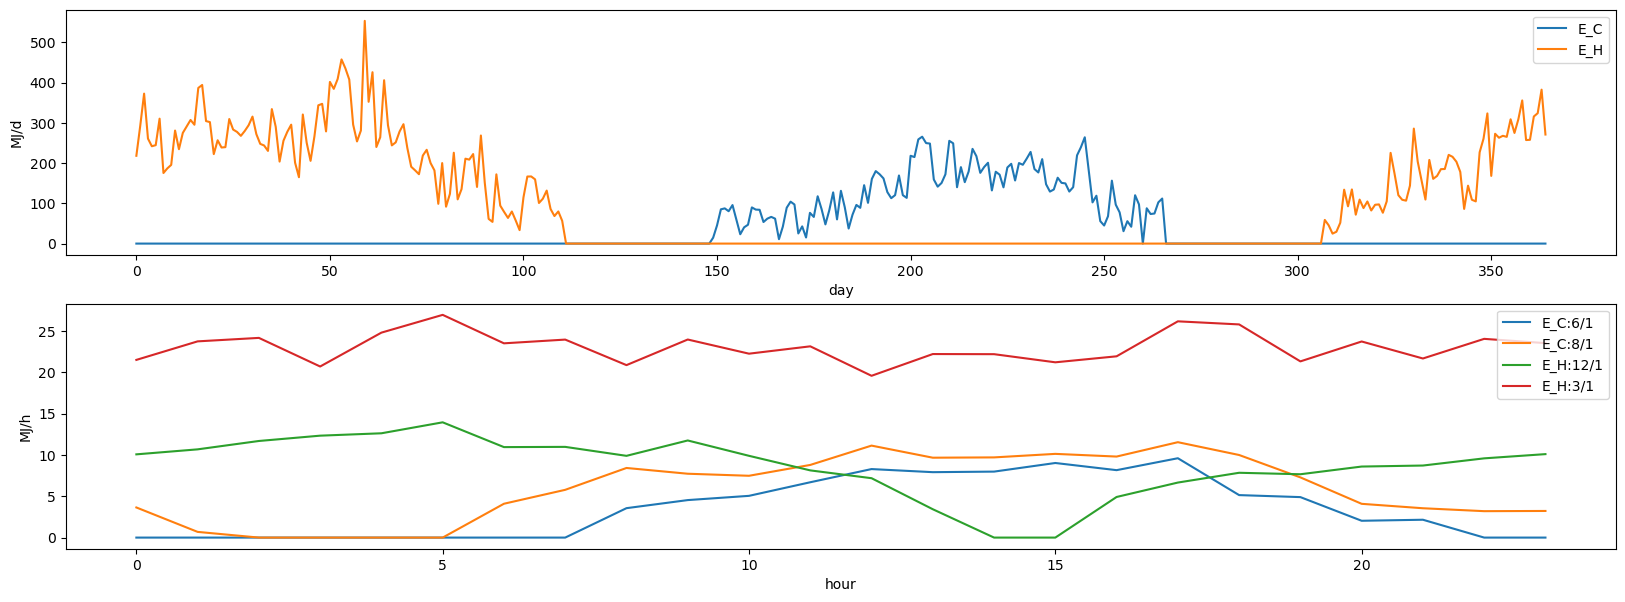

In [6]:
get_each_graph(_E_H_d_t_010, _E_C_d_t_010)

### 計算条件2

- ダクトが通過する空間を全て断熱区画内に変更
- VAV方式を採用するに変更
- 全般換気機能なしに変更
- 設計風量1500m3/hに変更

In [7]:
house_base, house_ENV, H_A, C_A = get_default_central_heating()
H_A['duct_insulation'] = '全て断熱区画内である'
H_A['VAV'] = True
H_A['general_ventilation'] = False
H_A['V_hs_dsgn_H'] = 1500
C_A['duct_insulation'] = '全て断熱区画内である'
C_A['VAV'] = True
C_A['general_ventilation'] = False
C_A['V_hs_dsgn_C'] = 1500

_E_H_d_t_020, _E_C_d_t_020 = calc_results(house_base, house_ENV, H_A, C_A)

E_H_d_t=33933.34325535101MJ/a
E_C_d_t=14439.173071090143MJ/a


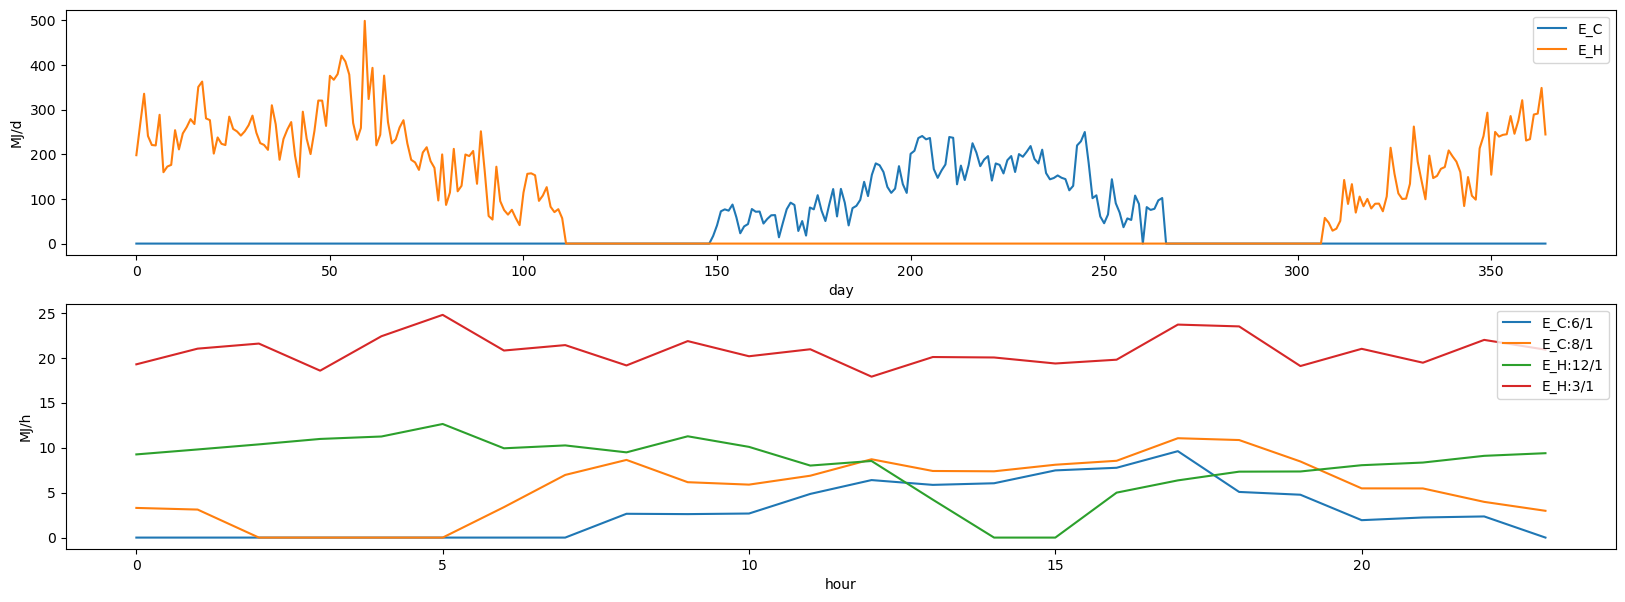

In [8]:
get_each_graph(_E_H_d_t_020, _E_C_d_t_020)

### 計算条件3

- 「定格能力試験の値を入力して計算する」に変更  
能力7500W、消費電力1800W、風量1500m3/h、室内側送風機の消費電力150W

In [9]:
house_base, house_ENV, H_A, C_A = get_default_central_heating()
H_A['EquipmentSpec'] = '定格能力試験の値を入力する'
H_A['q_hs_rtd_H'] = 7500
H_A['P_hs_rtd_H'] = 1800
H_A['V_fan_rtd_H'] = 1500
H_A['P_fan_rtd_H'] = 150

C_A['EquipmentSpec'] = '定格能力試験の値を入力する'
C_A['q_hs_rtd_C'] = 7500
C_A['P_hs_rtd_C'] = 1800
C_A['V_fan_rtd_C'] = 1500
C_A['P_fan_rtd_C'] = 150

_E_H_d_t_030, _E_C_d_t_030 = calc_results(house_base, house_ENV, H_A, C_A)

E_H_d_t=33206.02766257157MJ/a
E_C_d_t=12127.516574963209MJ/a


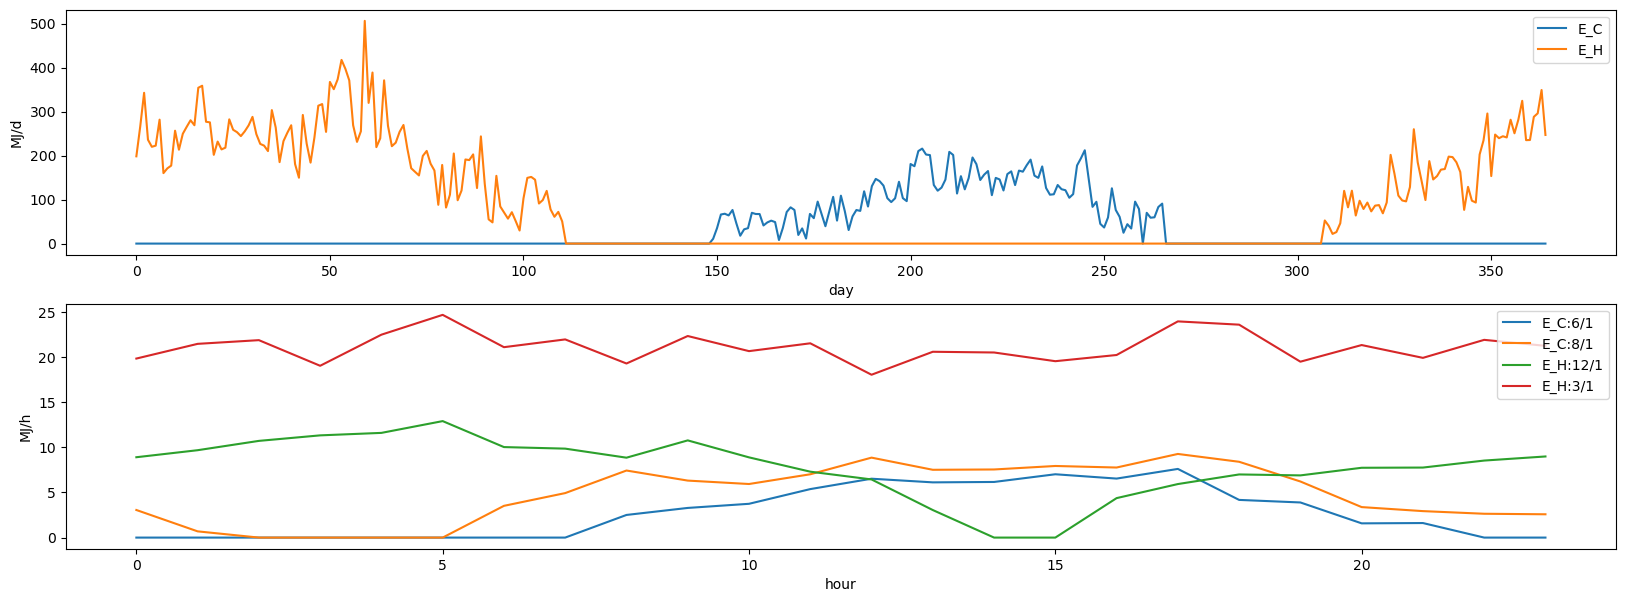

In [10]:
get_each_graph(_E_H_d_t_030, _E_C_d_t_030)

### 計算条件4

- 「定格能力試験と中間能力試験の値を入力して計算する」に変更  
定格暖房能力試験：能力7500W、消費電力1800W、風量1500m3/h、室内側送風機の消費電力150W  
中間暖房能力試験：能力3500W、消費電力700W、風量800m3/h、室内側送風機の消費電力80W  
定格冷房能力試験：能力7000W、消費電力1500W、風量1300m3/h、室内側送風機の消費電力140W  
中間冷房能力試験：能力3200W、消費電力600W、風量700m3/h、室内側送風機の消費電力70W

In [11]:
house_base, house_ENV, H_A, C_A = get_default_central_heating()
H_A['EquipmentSpec'] = '定格能力試験と中間能力試験の値を入力する'
H_A['q_hs_rtd_H'] = 7500
H_A['P_hs_rtd_H'] = 1800
H_A['V_fan_rtd_H'] = 1500
H_A['P_fan_rtd_H'] = 150
H_A['q_hs_mid_H'] = 3500
H_A['P_hs_mid_H'] = 700
H_A['V_fan_mid_H'] = 800
H_A['P_fan_mid_H'] = 80

C_A['EquipmentSpec'] = '定格能力試験と中間能力試験の値を入力する'
C_A['q_hs_rtd_C'] = 7000
C_A['P_hs_rtd_C'] = 1500
C_A['V_fan_rtd_C'] = 1300
C_A['P_fan_rtd_C'] = 140
C_A['q_hs_mid_C'] = 3200
C_A['P_hs_mid_C'] = 600
C_A['V_fan_mid_C'] = 700
C_A['P_fan_mid_C'] = 70

_E_H_d_t_040, _E_C_d_t_040 = calc_results(house_base, house_ENV, H_A, C_A)

E_H_d_t=31683.539998997214MJ/a
E_C_d_t=11132.00788497933MJ/a


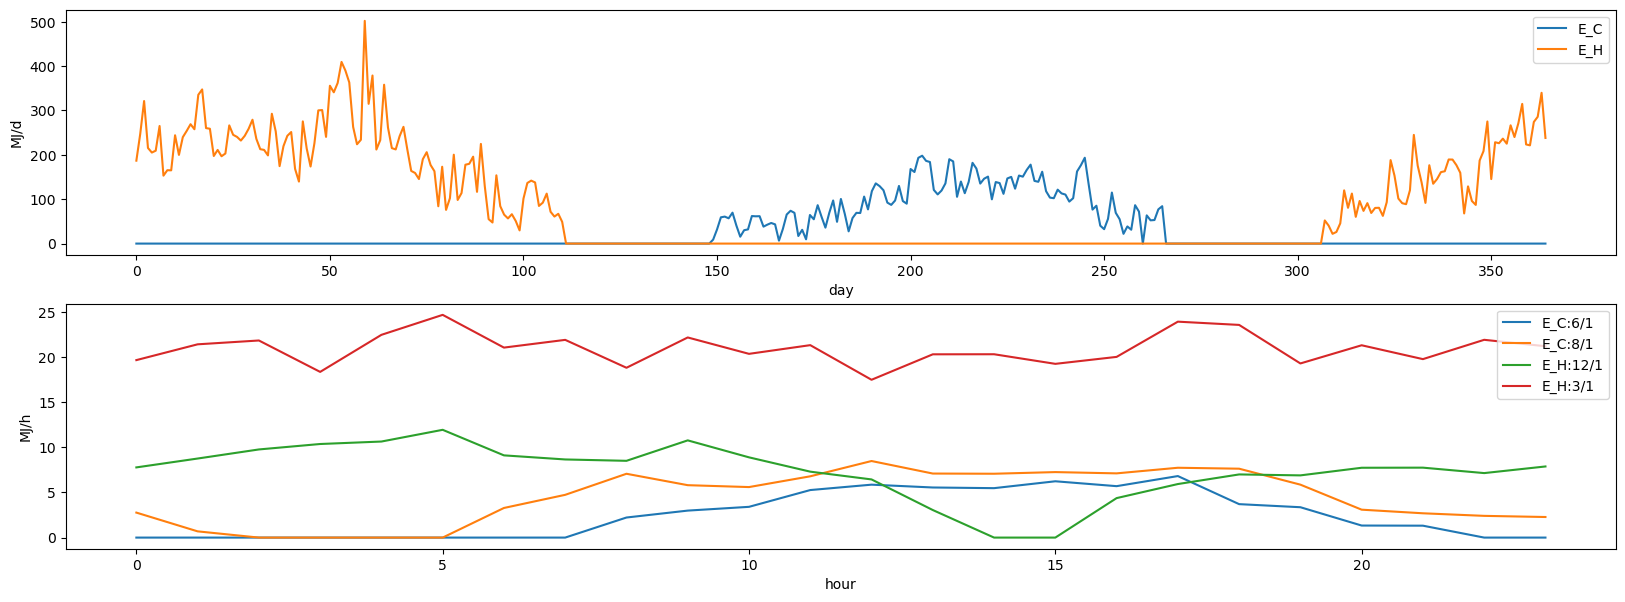

In [12]:
get_each_graph(_E_H_d_t_040, _E_C_d_t_040)

## 試算例の比較

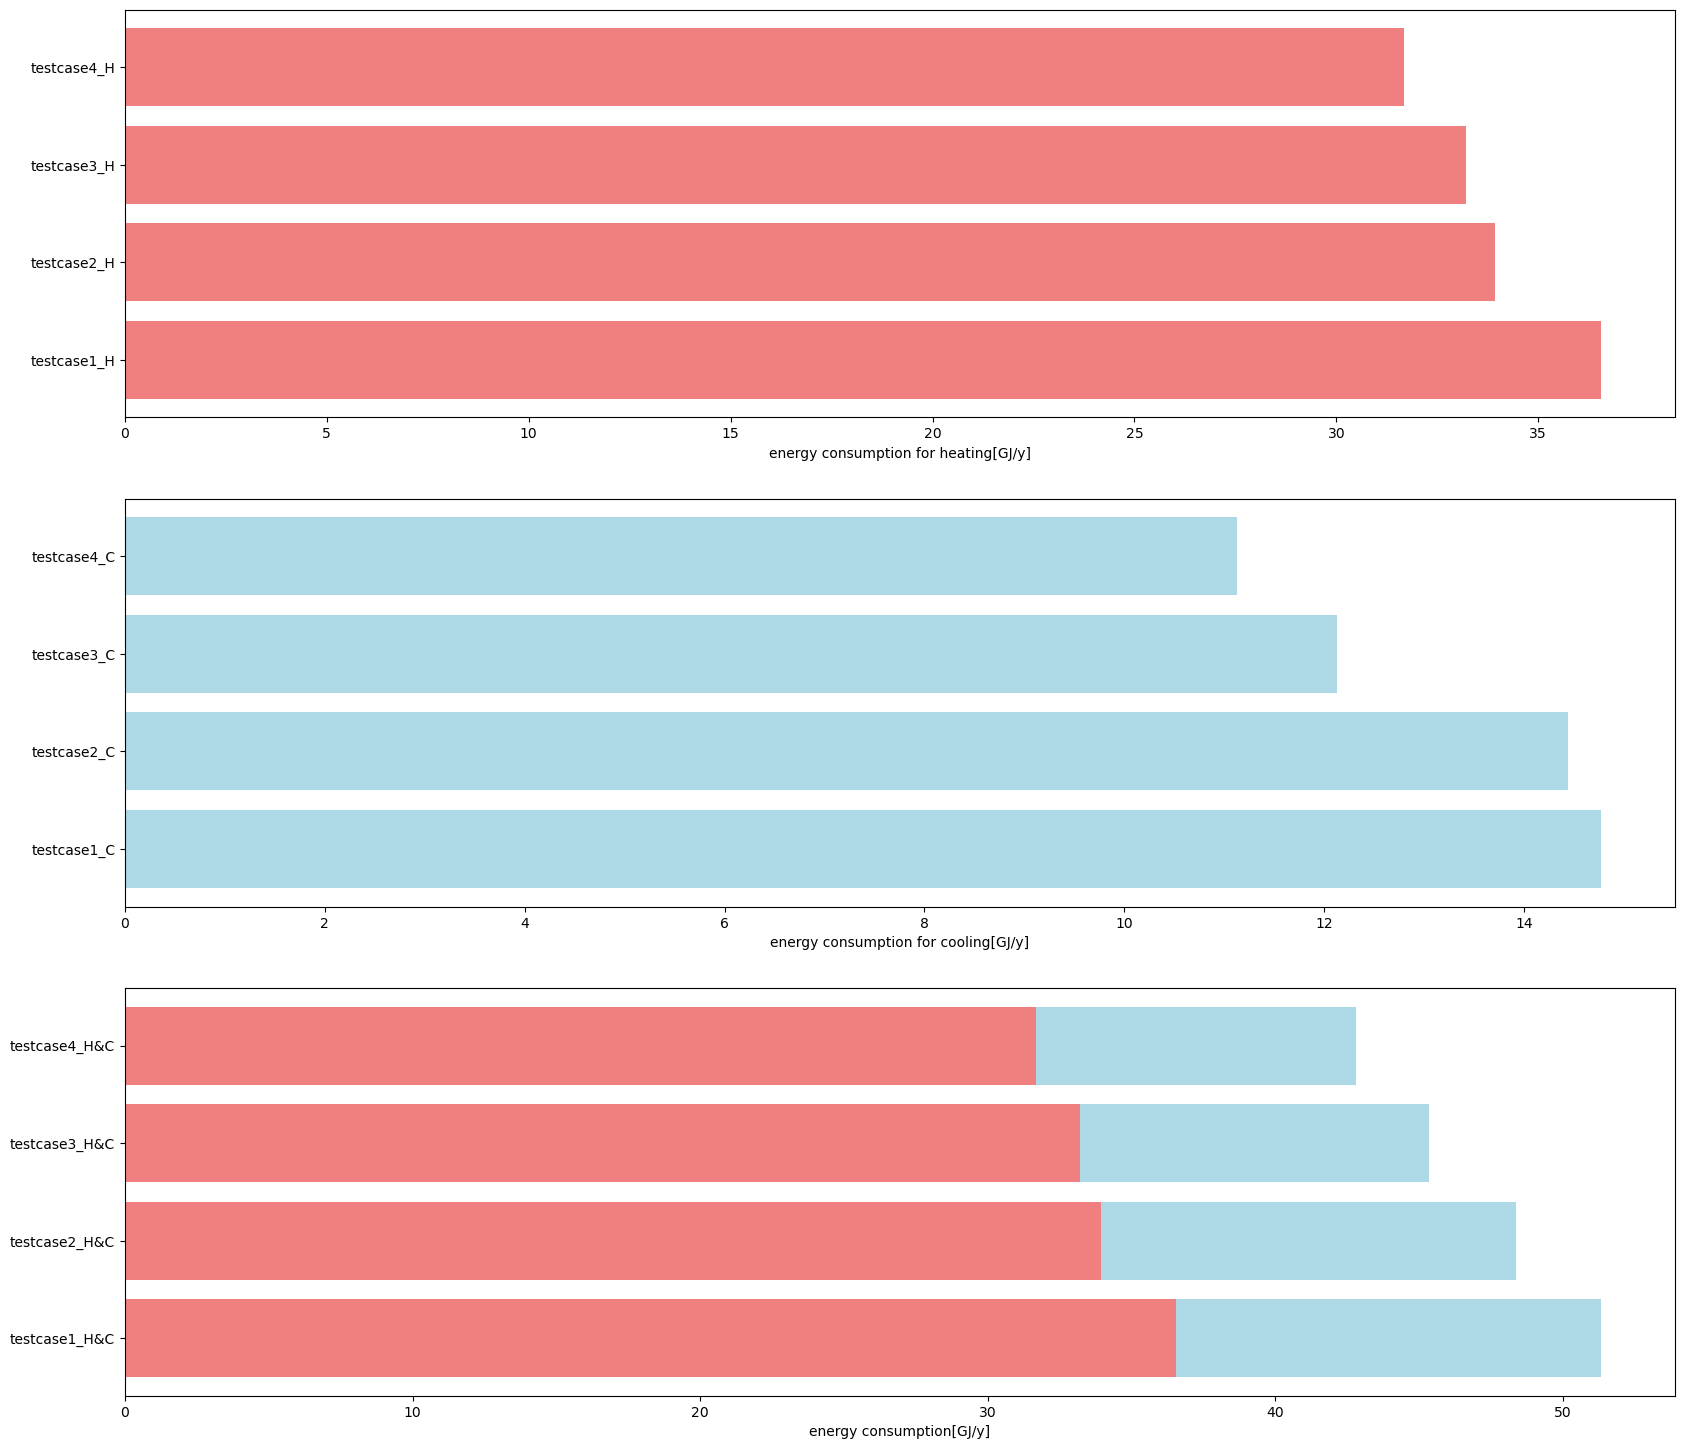

In [13]:
import matplotlib.pyplot as plt

dat_H = {"testcase1_H": np.sum(_E_H_d_t_010)/1000, "testcase2_H": np.sum(_E_H_d_t_020)/1000, "testcase3_H": np.sum(_E_H_d_t_030)/1000, 
         "testcase4_H": np.sum(_E_H_d_t_040)/1000}

dat_C = {"testcase1_C": np.sum(_E_C_d_t_010)/1000, "testcase2_C": np.sum(_E_C_d_t_020)/1000, "testcase3_C": np.sum(_E_C_d_t_030)/1000, 
         "testcase4_C": np.sum(_E_C_d_t_040)/1000}


x_H = list(dat_H.keys())
y_H = list(dat_H.values())

x_C = list(dat_C.keys())
y_C = list(dat_C.values())

x_HC = ["testcase1_H&C", "testcase2_H&C", "testcase3_H&C", "testcase4_H&C"]

fig = plt.figure(figsize=(20,18))

grh_H = fig.add_subplot(311)
grh_H.barh(x_H,y_H, color = "lightcoral")
grh_H.set_xlabel("energy consumption for heating[GJ/y]")

grh_C = fig.add_subplot(312)
grh_C.barh(x_C,y_C, color = "lightblue")
grh_C.set_xlabel("energy consumption for cooling[GJ/y]")

grh_HC = fig.add_subplot(313)
grh_HC.barh(x_HC,y_H, color = "lightcoral")
grh_HC.barh(x_HC,y_C, left=y_H, color = "lightblue")

grh_HC.set_xlabel("energy consumption[GJ/y]")


plt.show()